# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [57]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [58]:
# Only for kaggle
# !pip install torch_geometric

In [59]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [60]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
import random
from torch_geometric.utils import from_networkx
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, box

# to show advance in for loops
from tqdm import tqdm
from collections import defaultdict
import copy

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
# url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"
url_real = "D:\Grad\Planify_Dataset\Planify_Graphs_Scaled\Graphs_living_to_all.pkl"

url_boundary = r"D:\Grad\Planify_Dataset\Planify_Graphs_Scaled\boundaries.pkl"
model_path = "D:\Grad\Best models\v3_UnScalled\Best_model_V3.pt"

# for kaggle
# url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [61]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [62]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    



# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')
    
    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()
        
        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()
        
        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph
            
        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
            min_y = min_y_in_graph
            
    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values


def get_all_x_y(Graphs_pyTorch):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []

    for G in tqdm(Graphs_pyTorch, desc="getting all Xs, Ys", total=len(Graphs_pyTorch)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())

    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()
    

def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');

<a id='wrangling'></a>
## Data wrangling


In [63]:
with open(url_real, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)

Graph with 8 nodes and 7 edges


> Considering boundaries

In [64]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)
    
b = boundaries[1911]
print(b)

Graph with 9 nodes and 9 edges


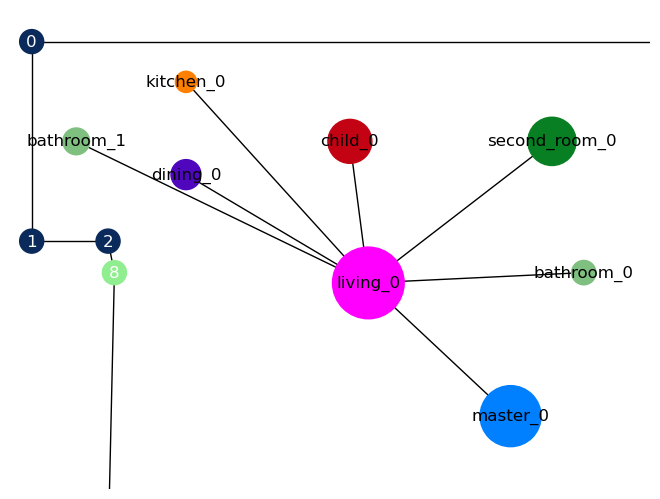

In [65]:
draw_graph_boundary(b)
draw_graph(G)

In [66]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)
    
Graphs_pyTorch[0]

100%|██████████| 80787/80787 [01:04<00:00, 1259.89it/s]


Data(edge_index=[2, 8], roomType_name=[5], rec_w=[5], rec_h=[5], roomSize=[5], x=[5, 3], edge_attr=[8, 1])

In [67]:
# Converting networkx boundary graphs to PyTorchGeo graphs
Boundaries_pyTorch = []
for b in tqdm(boundaries):
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    
    Boundaries_pyTorch.append(b_new)
    
Boundaries_pyTorch[0]

100%|██████████| 80787/80787 [01:18<00:00, 1023.98it/s]


Data(edge_index=[2, 18], x=[9, 3], edge_attr=[18, 1])

In [68]:
# copy_graphs = copy.deepcopy(Graphs_pyTorch)
# copy_bounds = copy.deepcopy(Boundaries_pyTorch)

> Statistics, To make normalization for x and y but to be able to get back to the real values

In [69]:
# getting maximum and minimum x, y for all graphs
get_max_min_x_y(Graphs_pyTorch)

Getting maximum x, y: 100%|██████████| 80787/80787 [00:07<00:00, 10667.49it/s]


{'max_x': 247.42583732057415,
 'max_y': 247.84313725490196,
 'min_x': 10.666666666666666,
 'min_y': 8.577319587628866}

In [70]:
x_g, y_g = get_all_x_y(Graphs_pyTorch)
x_g.max(), y_g.max(), x_g.min(), y_g.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:10<00:00, 7654.07it/s] 


(247.42583732057415, 247.84313725490196, 10.666666666666666, 8.577319587628866)

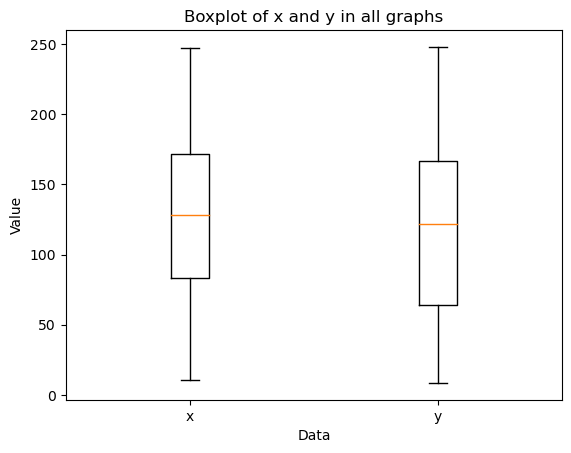

In [71]:
# making box plot for x and y for the graphs
boxplot_centrValues(x_g, y_g)

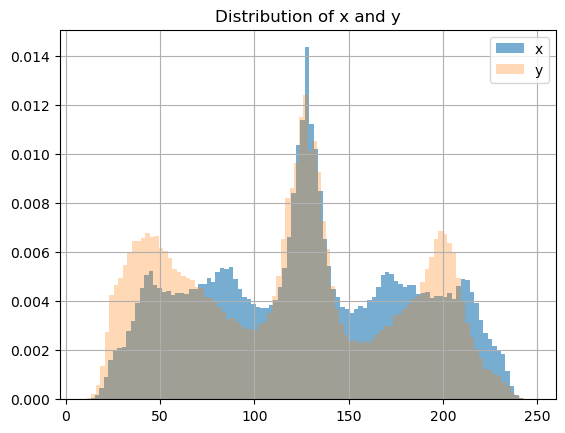

In [72]:
plot_histograms(x_g, y_g)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [73]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
x_g_mean = x_g.mean()
y_g_mean = y_g.mean()
x_g_std  = x_g.std()
y_g_std  = y_g.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [74]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  7.0000, 163.5824, 101.4260],
        [  7.0000, 134.9086, 201.0376]], dtype=torch.float64)


  2%|▏         | 1940/80787 [00:00<00:14, 5463.48it/s]

100%|██████████| 80787/80787 [00:08<00:00, 9035.27it/s] 

After: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  1.0000, 163.5824, 101.4260],
        [  1.0000, 134.9086, 201.0376]], dtype=torch.float64)


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [75]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        # mean = torch.mean(x[:, i])
        # std  = torch.std(x[:, i])
        if i == 1: # x
            mean = x_g_mean
            std  = x_g_std
        else: # y
            mean = y_g_mean
            std  = y_g_std
            
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:25<00:00, 3198.15it/s]


In [76]:
print(f"Now, we could return back to real values for last column: {Graphs_pyTorch[1].x.T[-1] * y_g_std + y_g_mean}")

Now, we could return back to real values for last column: tensor([153.2065, 196.9931,  34.7746, 140.5780, 101.8013, 101.4260, 201.0376],
       dtype=torch.float64)


> Normalizing the centroid of the boundaries

In [77]:
x, y = get_all_x_y(Boundaries_pyTorch)
x.max(), y.max(), x.min(), y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:18<00:00, 4283.93it/s]


(340.0875912408759, 306.0, -57.6, -86.6771653543307)

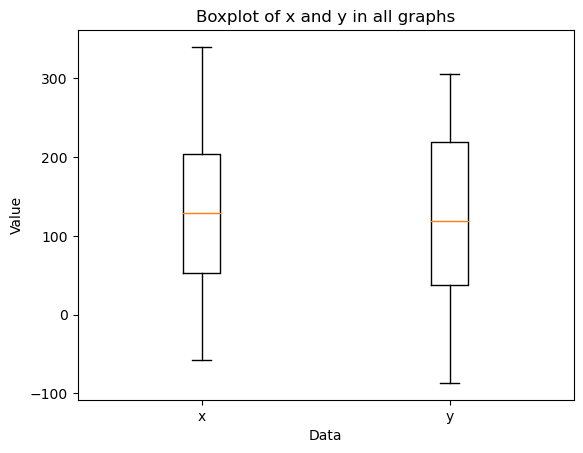

In [78]:
boxplot_centrValues(x, y)

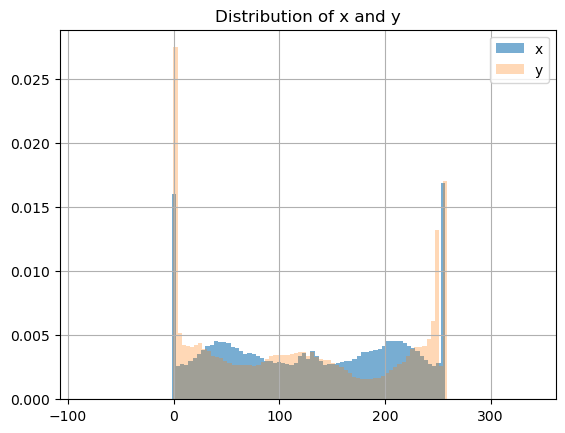

In [79]:
plot_histograms(x, y)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [80]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
x_b_mean = x.mean()
y_b_mean = y.mean()
x_b_std  = x.std()
y_b_std  = y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [81]:
for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):
    x = b.x # The feature matrix
    for i in [1, 2]:
        if i == 1: # for first column [x]
            mean = x_b_mean
            std  = x_b_std
        else: # for second column [y]
            mean = y_b_mean
            std  = y_b_std
            
        normalized_column = (x[:, i] - mean) / std
        b.x[:, i] = normalized_column

100%|██████████| 80787/80787 [00:08<00:00, 9159.86it/s] 


In [82]:
print(f"Now, we could return back to real values: {Boundaries_pyTorch[1].x.T[-2] * x_b_std + x_b_mean}")

Now, we could return back to real values: tensor([  3.6994, 101.3642, 252.3006, 252.3006, 197.5491, 197.5491,  49.5723,
         49.5723,   3.6994,  86.5665], dtype=torch.float64)


> If we need to creat graphs with padding by the maximum number of nodes.

In [83]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [84]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(self.device)
        B = self.Boundaries[index].clone().to(self.device)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)
        
        # shuffling nodes inside the same graph
        # permutation = torch.randperm(G.num_nodes).to(self.device)
        
        # G.x = G.x[permutation]
        # G.edge_index = permutation[G.edge_index]
        # G.rec_w = G.rec_w[permutation]
        # G.rec_h = G.rec_h[permutation]
        # G.edge_attr = G.edge_attr[permutation]
        
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        graphs = {
            'G': G,
            'B': B
        }
        
        return graphs

In [85]:
edge = int(len(Graphs_pyTorch) * 0.8)

In [86]:
batch_size = 1
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10], Boundaries_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:], Boundaries_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [87]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch.pt')
    # Saving model each 15 epochs
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)
    
    print('Model saved :)')

<a id='archi'></a>
### Architecture

In [88]:
from torch_geometric.nn import GlobalAttention
from torch_geometric.nn.dense import DenseGCNConv

class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        
        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)
        
        input_of_conv2   = num_graph_node_features + 32*4
        self.graph_conv2 = GATConv(input_of_conv2, 32, heads=8)
        
        input_of_conv3   = num_graph_node_features + 32*8
        self.graph_conv3 = GATConv(input_of_conv3, 64, heads=8)
        
        input_of_conv4   = num_graph_node_features + 64*8
        self.graph_conv4 = GATConv(input_of_conv4, 128, heads=8)
        # self.graph_conv5 = GATConv(128*8, 128, heads=8)
        # self.graph_conv6 = GATConv(128*8, 128, heads=16)
        # self.graph_conv7 = GATConv(128*16, 256, heads=16)
        # self.graph_conv8 = GATConv(256*16, 256, heads=16)
        shape_of_graphs_befor_concatination = num_graph_node_features + 128*8
        
        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)
        input_of_boundary_conv2 = 32*4 + num_boundary_node_features
        self.boundary_conv2 = GATConv(input_of_boundary_conv2, 32, heads=8)
        # self.boundary_conv3 = GATConv(32*8, 64, heads=8)
        # self.boundary_conv4 = GATConv(64*8, 128, heads=8)
        # self.boundary_conv5 = GATConv(128*8, 128, heads=8)
        shape_of_boundary_befor_concatination = num_boundary_node_features + 32 * 8
        
        # Output of graph_conv8 + output of boundary_conv5 + 2 step connection from real nodes and boundary nodes
        inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
        self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)
        # self.Concatination2  = GATConv(128*8, 64, heads=8)
        # self.Concatination3  = GATConv(64*8, 64, heads=8)
        # self.Concatination4  = GATConv(64*8, 32, heads=8)
        # self.Concatination5  = GATConv(32*8, 32*4)
        
        # self.lin1 = nn.Linear(inputs_concatination, 256)
        # self.lin2 = nn.Linear(256, 32)

        self.width_layer1  = nn.Linear(128*8, 128)
        self.height_layer1 = nn.Linear(128*8, 128)
        
        # self.width_layer2  = nn.Linear(256, 128)
        # self.height_layer2 = nn.Linear(256, 128)
        
        # self.width_layer3  = nn.Linear(128, 32)
        # self.height_layer3 = nn.Linear(128, 32)
        
        # self.width_layer4  = nn.Linear(32, 8)
        # self.height_layer4 = nn.Linear(32, 8)
        
        self.width_output  = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)
        
        
        self.boundary_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr, g_batch = graph.x.to(torch.float32), graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x.to(torch.float32), boundary.edge_index, boundary.edge_attr, boundary.batch
        
        NUM_OF_NODES = x_graph.shape[0]
        # During testing, as we input only one graph.
        if g_batch == None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if b_batch == None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        
        x_graph_res = x_graph
        x_boundary_res = x_boundary
        
        # Passing the graph throught a message passing to embed its features
        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph) # Concatinate with step connection from real values.
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        
        x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        # x_graph = F.leaky_relu(self.graph_conv5(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv6(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)
        # x_graph = F.leaky_relu(self.graph_conv7(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv8(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)
        
        
        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
        x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
        # x_boundary = F.leaky_relu(self.boundary_conv3(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)
        # x_boundary = F.leaky_relu(self.boundary_conv4(x_boundary, b_edge_indexy))
        # x_boundary = F.leaky_relu(self.boundary_conv5(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)

        # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination2(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination3(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination4(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination5(x, g_edge_index))
        # x = self.dropout(x)
        
        # x = F.leaky_relu(self.lin1(x))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.lin2(x))
        # x = self.dropout(x)
        
        
        width = F.leaky_relu(self.width_layer1(x))
        # width = F.leaky_relu(self.width_layer2(width))
        # width = F.leaky_relu(self.width_layer3(width))
        # width = F.leaky_relu(self.width_layer4(width))
        width = self.dropout(width)
        width = self.width_output(width)
        
        height = F.leaky_relu(self.height_layer1(x))
        # height = F.leaky_relu(self.height_layer2(height))
        # height = F.leaky_relu(self.height_layer3(height))
        # height = F.leaky_relu(self.height_layer4(height))
        height = self.dropout(height)
        height = self.height_output(height)
        
        return width.squeeze(), height.squeeze()

num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(137, 32, heads=8)
  (graph_conv3): GATConv(265, 64, heads=8)
  (graph_conv4): GATConv(521, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1292, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (boundary_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [89]:
checkpoint_path = r"D:\Grad\Best models\v3_UnScalled\Best_model_V3.pt"
checkpoint = torch.load(checkpoint_path)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']

model.eval()

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(137, 32, heads=8)
  (graph_conv3): GATConv(265, 64, heads=8)
  (graph_conv4): GATConv(521, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1292, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (boundary_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [90]:
from shapely.geometry import Polygon
from shapely.ops import unary_union


poly1 = Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])  # Square polygon
poly2 = Polygon([(1, 1), (3, 1), (3, 3), (1, 3)])  # Another square polygon

# Check if polygons intersect
if poly1.intersects(poly2):
    intersection = poly1.intersection(poly2)
    poly1 = poly1.difference(intersection.buffer(0.09))  # Adjust the buffer distance as needed
    combined_polygon = unary_union([poly1, poly2])
# else:
    combined_polygon = unary_union([poly1, poly2])

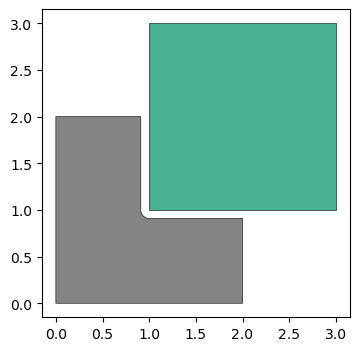

In [91]:
gpd.GeoSeries([poly1, poly2]).plot(cmap='Dark2_r', figsize=(4, 4), alpha=0.8, linewidth=0.5, edgecolor='black');

In [92]:
class FloorPlan_multipolygon():
    def __init__(self, graph, prediction=None):
        self.graph       = graph
        self.prediction  = prediction
        
    def get_room_data(self, room_index):
        """
        Inputs: 
            room_index: index of the room in the graph
            
        Outputs: 
            centroid, w, h of that room.
        """
        # # Using networkX graphs
        # Graph_data = list(self.graph.nodes(data=True))[room_index][1]
        # w = Graph_data['rec_w']
        # h = Graph_data['rec_h']
        # centroid = (Graph_data['actualCentroid_x'], Graph_data['actualCentroid_y'])
        # category = Graph_data['roomType_embd']
        
        # Using pytorhc Garphs
        w = self.graph.rec_w[room_index].item()
        h = self.graph.rec_h[room_index].item()
        centroid = (self.graph.x[room_index][-2].item(), self.graph.x[room_index][-1].item())
        category = torch.argmax(self.graph.x[:, :7][room_index]).item()
        
        if isinstance(self.prediction, tuple): # A  real array of predictions
            w_pre, h_pre = self.get_predictions(room_index)
            
        else:
            w_pre, h_pre = None, None
            
        data = {
            'centroid': centroid,
            'real_w': w,
            'real_h': h, 
            'predic_w': w_pre,
            'predic_h': h_pre,
            'category': category
        }
        return data
    
    def create_box(self, room_data):
        """
        Inputs:
            room_data: a dictionary with centroid, w, h of that room.
            
        Outputs:
            box: a shapely box with the same centroid, w, h of that room.
        """
        
        centroid = room_data['centroid']
        # print(centroid)
        if isinstance(self.prediction, tuple): # A  real array of predictions
            half_w   = room_data['predic_w'] / 2
            half_h   = room_data['predic_h'] / 2
        
        else:
            half_w   = room_data['real_w'] / 2
            half_h   = room_data['real_h'] / 2

        # bottom_left  = Point(centroid[0] - half_w, centroid[1] - half_h)
        # bottom_right = Point(centroid[0] + half_w, centroid[1] - half_h)
        # top_right    = Point(centroid[0] + half_w, centroid[1] + half_h)
        # top_left     = Point(centroid[0] - half_w, centroid[1] + half_h)
        
        x1 = centroid[0] - half_w
        x2 = centroid[0] + half_w
        y1 = centroid[1] - half_h
        y2 = centroid[1] + half_h
        
        # print(bottom_left, bottom_right, top_right, top_left)
        # box = Polygon([bottom_left, bottom_right, top_right, top_left])
        box_poly = box(x1, y1, x2, y2)
        return box_poly

    def get_multipoly(self, boundary=False, door=False):
        """
        Outputs:
            multi_poly: a shapely multipolygon of all the rooms in the floor plan or graph.
        """
        num_of_rooms = self.graph.x.shape[0]
        similar_polygons = defaultdict(list)
        
        for index in range(num_of_rooms):
            room_data = self.get_room_data(index)
            box = self.create_box(room_data)
            box = box.intersection(boundary.buffer(-3, cap_style=3, join_style=2))
        
            # add each pox to its similar boxes
            room_category = room_data['category']
            if room_category != 0:
                similar_polygons[room_category].append(box)
        

        all_polygons = []
        all_polygons.append(boundary)
        similar_polygons_2 = defaultdict(list)
        for room_category, polygons in similar_polygons.items():
            if room_category in (2, 3): # If bathroom or kitchen.
                # combined_polygon = unary_union(polygons)
                # all_polygons.append(combined_polygon)
                # for poly in polygons:
                #     similar_polygons_2[room_category].append(poly)
                
                for bath_or_kitchen in polygons:
                    if any(bath_or_kitchen.intersects(room) for room in similar_polygons[1]): # Chcek if the current bathroom or kitchen intersectes with any room
                        for i, room in enumerate(similar_polygons[1]):
                            if bath_or_kitchen.intersects(room):
                                intersection = bath_or_kitchen.intersection(room)
                                if intersection.area >= (0.3 * bath_or_kitchen.area):
                                    # new_bath_or_kitchen = intersection
                                    print('>= 50%')
                                    bath_or_kitchen = bath_or_kitchen.intersection(room.buffer(-3, cap_style=3, join_style=2))
                                    # bath_or_kitchen   = room.intersection(bath_or_kitchen.buffer(-3, cap_style=3, join_style=3))
                                else:
                                    print('Not >= 50%')
                                    ## If we need to cut from the room
                                    # new_room = room.difference(intersection.buffer(50))
                                    # similar_polygons[1][i] = new_room
                                    
                                    ## If we need to cut from the bathroom or kitchen
                                    bath_or_kitchen = bath_or_kitchen.difference(intersection.buffer(4))
                                    
                    similar_polygons_2[room_category].append(bath_or_kitchen)

            else: # If rooms
                existing_polygons = []
                for poly in polygons: # for room in rooms
                    # print(f'Current poly: {poly.centroid}')
                    if any(poly.intersects(exist) for exist in existing_polygons):
                        for exist in existing_polygons:
                            if poly.intersects(exist): # If there is an intersection between current poly and the checking polygon.
                                # print(f'Intersects with: {exist.centroid}')
                                intersection = poly.intersection(exist)
                                if exist.area > poly.area:
                                    # print('1')
                                    difference_polygon = exist.difference(intersection.buffer(4))
                                    
                                    # We cut from the exist so we will remove the old version and add the new version.
                                    similar_polygons_2[room_category].remove(exist)
                                    similar_polygons_2[room_category].append(difference_polygon)
                                    
                                    # Also we add the current polygon.
                                    similar_polygons_2[room_category].append(poly)
                                    
                                    # The same step we didi in similar_polygons_2 we make it here to make the existing_polys the same.
                                    existing_polygons.remove(exist)
                                    existing_polygons.append(difference_polygon)
                                    
                                    existing_polygons.append(poly)
                                    
                                else:
                                    # print('2')
                                    difference_polygon = poly.difference(intersection.buffer(4))
                                    similar_polygons_2[room_category].append(difference_polygon)
                                    # existing_polygons.append(difference_polygon)
                                    # similar_polygons_2[room_category].append(exist)
                                    
                    else: # For the first one
                        # print('No intersection')
                        existing_polygons.append(poly)
                        similar_polygons_2[room_category].append(poly)
                        
                        
        for _, polygons in similar_polygons_2.items():
            all_polygons.append(MultiPolygon(polygons))
        
        if door:
            all_polygons.append(door)
            
        compined_polygons_seperated = gpd.GeoSeries(all_polygons)
        
        return compined_polygons_seperated
        
    def get_predictions(self, room_index):
        """
        Inputs: 
            room_index: index of the room in the graph
        outputs: 
            w_predicted: predicted width for that room
            h_predicted: predicted width for that room
        """
        w_predicted = self.prediction[0]
        h_predicted = self.prediction[1]
        
        return w_predicted[room_index], h_predicted[room_index]

In [93]:
rand = np.random.randint(0, 80000)
Graph_index = rand
print(rand)
# Graph and Boundary with normalized x, y
G = Graphs_pyTorch[Graph_index]
B = Boundaries_pyTorch[Graph_index]

# Using the same data types in boundaries as in graphs, must for the model.
B.x = B.x.to(G.x.dtype)
B.edge_index = B.edge_index.to(G.edge_index.dtype)
B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)

# Get our predictions
predictions = model(G.to(device), B.to(device))


# Get back the real x, y of the centroids to put them in their real places.
G = Graphs_pyTorch[Graph_index]
G.x[:, -2] = G.x[:, -2] * x_g_std + x_g_mean
G.x[:, -1] = G.x[:, -1] * y_g_std + y_g_mean

B.x[:, -2] = B.x[:, -2] * x_b_std + x_b_mean
B.x[:, -1] = B.x[:, -1] * y_b_std + y_b_mean

55768


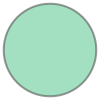

In [94]:
the_door = Point(B.x[-1][1:].detach().cpu().numpy())
the_door.buffer(3)

### Real graph

<Axes: >

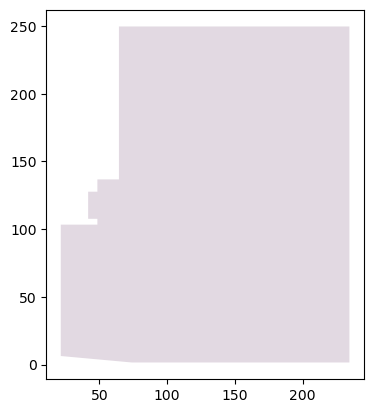

In [113]:
Bou_x = B.x[:-1, :]
# Bou_x = B.x
boundary_centroids = [(Bou_x[n-1, -2:][0].item(), Bou_x[n-1, -2:][1].item()) for n in range(len(Bou_x))]
boundary_polygon = Polygon(boundary_centroids)


hi = unary_union([boundary_polygon, the_door.buffer(10, cap_style=3, join_style=2)])
gpd.GeoSeries(hi).plot(cmap='twilight');

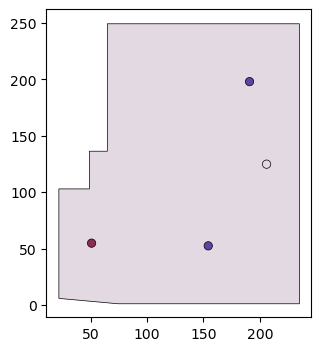

In [121]:
inputs = G.x.detach().cpu().numpy()
polys = defaultdict(list)

for poly in inputs:
    type = np.argmax(poly[:-2])
    if type != 0:
        point = poly[-2:]
        polys[type].append(Point(point))

Input_format = []
Input_format.append(boundary_polygon)

for _, points in polys.items():
            Input_format.append(unary_union(points))
            
gpd.GeoSeries(Input_format).plot(cmap='twilight', figsize=(4, 4), alpha=1, linewidth=0.5, edgecolor='black');

In [97]:
# Paired Dark2_r Accent Set1_r Set2_r Set3_r Pastel1_r Pastel2_r Pastel1 Pastel2

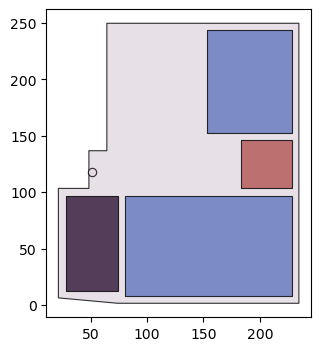

In [98]:
f = FloorPlan_multipolygon(G, prediction=None)
polys = f.get_multipoly(boundary_polygon, the_door);
polys.plot(cmap='twilight', figsize=(4, 4), alpha=0.8, linewidth=0.8, edgecolor='black');

### Predicted graph

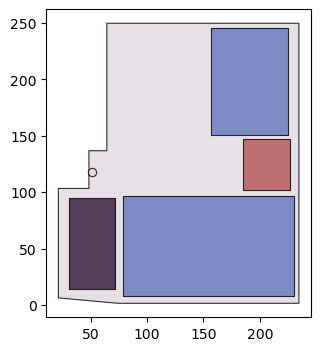

In [99]:
w = predictions[0].detach().cpu().numpy()
h = predictions[1].detach().cpu().numpy()
w_h_predicted = (w, h)

test = FloorPlan_multipolygon(G, prediction=w_h_predicted)

polys = test.get_multipoly(boundary_polygon, the_door);
polys.plot(cmap='twilight', figsize=(4, 4), alpha=0.8, linewidth=0.8, edgecolor='black');